# Capstone

## Prepare Notebook

Install pydicom

In [1]:
!pip install pydicom

Defaulting to user installation because normal site-packages is not writeable


In [2]:
!pip install torch

Defaulting to user installation because normal site-packages is not writeable


In [3]:
!pip install torchvision

Defaulting to user installation because normal site-packages is not writeable


Mount Google Drive

In [4]:
#from google.colab import drive
#drive.mount('/content/drive')

Set Paths

In [5]:
import os

#path = '/content/drive/MyDrive/SIADS_699_Capstone/Capstone_Team_Project' #Google Drive path
path = '/home/ausgear' #Great Lakes
data_path = os.path.join(path, 'data/rsna-pneumonia')
img_path = os.path.join(data_path, 'stage_2_train_images')
obj_path = os.path.join(path, 'python_objects')

In [6]:
os.getcwd()

'/home/ausgear'

## Custom Dataset Class

Definition

In [7]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import pydicom
from PIL import Image

#Custom Dataset Class
class CustomImageDataset(Dataset):
    def __init__(self, annotations_file, img_dir, indices=None, transform=None, target_transform=None):
        if indices:
            self.img_labels = pd.read_csv(annotations_file).iloc[indices]
        else:
            self.img_labels = pd.read_csv(annotations_file)
        self.img_dir = img_dir
        self.transform = transform
        self.target_transform = target_transform

    def __len__(self):
        return len(self.img_labels)

    def __getitem__(self, idx):
        filename = self.img_labels.iloc[idx, 0] + '.dcm'
        img_path = os.path.join(self.img_dir, filename)
        ds = pydicom.dcmread(img_path)
        img_arr = ds.pixel_array
        image = Image.fromarray(img_arr)
        label = self.img_labels.iloc[idx, -1]
        if self.transform:
            image = self.transform(image)
        if self.target_transform:
            label = self.target_transform(label)
        return (image, label)

    def get_classes(self):
        return self.img_labels.iloc[:, -1].unique()

    def display_img(self, idx):
        img = self.__getitem__(idx)[0]
        plt.imshow(img, cmap=plt.cm.bone)
        return None

    classes = property(get_classes)

In [8]:
from sklearn.model_selection import train_test_split

annotations_file = os.path.join(data_path, 'stage_2_train_labels.csv')
label_df = pd.read_csv(annotations_file)
display(label_df.head())

X_train, X_val = train_test_split(label_df, test_size=0.2, stratify=label_df['Target'], random_state=42)
X_val, X_test = train_test_split(X_val, test_size=0.5, stratify=X_val['Target'], random_state=42)
X_train, X_val, X_test = X_train.index.tolist(), X_val.index.tolist(), X_test.index.tolist()

print(len(X_train))
print(len(X_val))
print(len(X_test))

,patientId,x,y,width,height,Target
0,0004cfab-14fd-4e49-80ba-63a80b6bddd6,NaN,NaN,NaN,NaN,0
1,00313ee0-9eaa-42f4-b0ab-c148ed3241cd,NaN,NaN,NaN,NaN,0
2,00322d4d-1c29-4943-afc9-b6754be640eb,NaN,NaN,NaN,NaN,0
3,003d8fa0-6bf1-40ed-b54c-ac657f8495c5,NaN,NaN,NaN,NaN,0
4,00436515-870c-4b36-a041-de91049b9ab4,264.0,152.0,213.0,379.0,1


24181
3023
3023


Initialize

In [9]:
from torchvision import transforms

mean = 0.5
std = 0.5
#Transforms
transforms = dict(
  train = transforms.Compose([
      transforms.Resize(256),
      transforms.RandomHorizontalFlip(.1),
      transforms.RandomRotation(degrees=(-7, 7)),
      transforms.ToTensor(),
      transforms.Normalize(mean, std),
  ]),
  eval = transforms.Compose([
      transforms.Resize(256),
      transforms.ToTensor(),
      transforms.Normalize(mean, std),
  ])
)

#Initialize Dataset
train_dataset = CustomImageDataset(annotations_file, img_path, indices=X_train[:5000], transform=transforms['train'])
val_dataset = CustomImageDataset(annotations_file, img_path, indices=X_val, transform=transforms['eval'])
test_dataset = CustomImageDataset(annotations_file, img_path, indices=X_test, transform=transforms['eval'])

## Dataloaders

Initialize

In [10]:
#Dataloader Hyperparameters
batch_size = 32
shuffle = True
pin_memory = False
num_workers = 1

#Initialize Dataloader
train_dataloader = DataLoader(dataset=train_dataset, shuffle=shuffle, batch_size=batch_size, num_workers=num_workers, pin_memory=pin_memory)
validation_dataloader = DataLoader(dataset=val_dataset, shuffle=shuffle, batch_size=batch_size, num_workers=num_workers, pin_memory=pin_memory)
test_dataloader = DataLoader(dataset=test_dataset, shuffle=shuffle, batch_size=batch_size, num_workers=num_workers, pin_memory=pin_memory)

print(len(train_dataloader.dataset)//batch_size)

156


Benchmark batch load time

Feature batch shape: torch.Size([32, 1, 256, 256])
Labels batch shape: 32


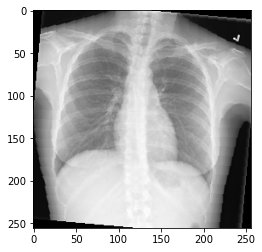

Label: 0
tensor([[-1., -1., -1.,  ..., -1., -1., -1.],
        [-1., -1., -1.,  ..., -1., -1., -1.],
        [-1., -1., -1.,  ..., -1., -1., -1.],
        ...,
        [-1., -1., -1.,  ..., -1., -1., -1.],
        [-1., -1., -1.,  ..., -1., -1., -1.],
        [-1., -1., -1.,  ..., -1., -1., -1.]])
CPU times: user 120 ms, sys: 31.2 ms, total: 151 ms
Wall time: 1.41 s


In [11]:
%%time
# Display image and label.
train_features, train_labels = next(iter(train_dataloader))
print(f"Feature batch shape: {train_features.size()}")
print(f"Labels batch shape: {len(train_labels)}")
img = train_features[0].squeeze()
label = train_labels[0]
plt.imshow(img, cmap="gray")
plt.show()
print(f"Label: {label}")
print(img)

Export Dataloader to file

In [12]:
torch.save(train_dataloader, obj_path + '/train_dataloader.pth')
torch.save(validation_dataloader, obj_path + '/validation_dataloader.pth')
torch.save(test_dataloader, obj_path + '/test_dataloader.pth')

In [13]:
#train_reloaded = torch.load(obj_path + '/train_dataloader.pth')

## CNN

Definition

In [25]:
import torch.optim as optim
from torch.optim.lr_scheduler import ExponentialLR

def checkpoint(model, best_loss, epoch, LR, path):
    print('saving')
    state = {
        'model': model,
        'best_loss': best_loss,
        'epoch': epoch,
        'rng_state': torch.get_rng_state(),
        'LR': LR
    }

    torch.save(state, os.path.join(path, 'checkpoint') )
    
class LeNet(torch.nn.Module):
    def __init__(self, num_channels, classes):
        super(LeNet, self).__init__()

        self.conv1 = torch.nn.Conv2d(in_channels=num_channels, out_channels=20, kernel_size=20)
        self.relu1 = torch.nn.ReLU()
        self.maxpool1 = torch.nn.MaxPool2d(kernel_size=(2, 2), stride=(2, 2))

        self.conv2 = torch.nn.Conv2d(in_channels=20, out_channels=50, kernel_size=(5, 5))
        self.relu2 = torch.nn.ReLU()
        self.maxpool2 = torch.nn.MaxPool2d(kernel_size=(2, 2), stride=(2, 2))

        self.fc1 = torch.nn.Linear(in_features=162450, out_features=500)
        self.relu3 = torch.nn.ReLU()

        self.fc2 = torch.nn.Linear(in_features=500, out_features=classes)
        self.logSoftmax = torch.nn.LogSoftmax(dim=1)

    def forward(self, x):
        x = self.conv1(x)
        x = self.relu1(x)
        x = self.maxpool1(x)

        x = self.conv2(x)
        x = self.relu2(x)
        x = self.maxpool2(x)

        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = self.relu3(x)

        x = self.fc2(x)
        output = self.logSoftmax(x)

        return output

init_learning_rate = 1e-2

print(torch.cuda.is_available())
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = LeNet(num_channels=1, classes=len(train_dataloader.dataset.classes)).to(device)

opt = optim.SGD(model.parameters(), lr=init_learning_rate)
scheduler = ExponentialLR(opt, gamma=0.9)

loss_fn = nn.NLLLoss()

True


In [26]:
import datetime

best_loss = 1e+8
best_epoch = 0
epochs = 5

for epoch in range(epochs):
    model.train()

    total_training_loss = 0
    total_val_loss = 0

    train_correct = 0
    val_correct = 0

    for train_idx, (x, y) in enumerate(train_dataloader):

        if train_idx % 10 == 0:
            print(f'train idx: {train_idx} and time: {datetime.datetime.now().time()}')

        x, y = x.to(device), y.to(device)

        pred = model(x)
        loss = loss_fn(pred, y)

        opt.zero_grad()
        loss.backward()
        opt.step()

        total_training_loss += loss
        train_correct += (pred.argmax(1) == y).type(torch.float).sum().item()

    with torch.no_grad():
        model.eval()

        for val_idx, (x, y) in enumerate(validation_dataloader):

            if val_idx % 10 == 0:
                print(f'val idx: {val_idx} and time: {datetime.datetime.now().time()}')

            (x, y) = (x.to(device), y.to(device))
            pred = model(x)
            total_val_loss += loss_fn(pred, y)
            val_correct += (pred.argmax(1) == y).type(torch.float).sum().item()
        
    # break if no val loss improvement in 3 epochs
    if ((epoch - best_epoch) >= 3):
        print("no improvement in 3 epochs, break")
        break

    lr = next(iter(opt.param_groups))['lr']
    
    print('Epoch {} completed - train loss: {:.4f} train correct pred: {} val loss {:4f} val correct pred: {}'.format(
      epoch+1, total_training_loss, train_correct, total_val_loss, val_correct))

    # checkpoint model if has best val loss yet
    if total_val_loss < best_loss:
        best_loss = total_val_loss
        best_epoch = epoch
        checkpoint(model, best_loss, epoch, lr, obj_path)

    scheduler.step()

train idx: 0 and time: 21:27:45.689931
train idx: 10 and time: 21:27:49.067967
train idx: 20 and time: 21:27:52.481795
train idx: 30 and time: 21:27:55.884783
train idx: 40 and time: 21:27:59.272789
train idx: 50 and time: 21:28:02.663085
train idx: 60 and time: 21:28:06.062256
train idx: 70 and time: 21:28:09.457559
train idx: 80 and time: 21:28:12.856255
train idx: 90 and time: 21:28:16.233276
train idx: 100 and time: 21:28:19.614377
train idx: 110 and time: 21:28:22.981079
train idx: 120 and time: 21:28:26.389325
train idx: 130 and time: 21:28:29.739806
train idx: 140 and time: 21:28:33.109525
train idx: 150 and time: 21:28:36.488139
val idx: 0 and time: 21:28:39.219100
val idx: 10 and time: 21:28:42.471765
val idx: 20 and time: 21:28:45.743951
val idx: 30 and time: 21:28:49.011548
val idx: 40 and time: 21:28:52.271684
val idx: 50 and time: 21:28:55.502906
val idx: 60 and time: 21:28:58.737036
val idx: 70 and time: 21:29:01.984056
val idx: 80 and time: 21:29:05.215588
val idx: 90 an